## Analysis for 4C for Children

This analysis was requested by **4C for Children**, a nonprofit organization.  

4C for Children is a **Child Care Resource & Referral Agency** that supports everyone who cares for young children—ranging from parents to child care providers. The organization's mission is to ensure **high-quality early education and care** for all children.

A questionaire was presented to childcare centers and in-home childcare centers (Family Childcare Centers/FCCs) to assess their ability to fill classes. A secondary purpose is to identify those who might need assistance in understanding or utilizing the "Step Up to Quality" rating system. The results of that questionaire was collected into an excel spreadsheet and this analysis will focus on Centers and attempt to identify the gap to get to "full" for each of classes: Infant, Toddler, Preschool and School Age. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# bring in 2 files, one for data and one as a map to help shorten column names where possible
data_file_path = "State of Childcare Survey.xlsx"
mapping_file_path = "Column Mappings.xlsx"
df = pd.read_excel(data_file_path)
mapping_df = pd.read_excel(mapping_file_path)
#print(df.head())
#print(mapping_df.head())

column_mapping = dict(zip(mapping_df['Old Name'], mapping_df['New Name']))
df = df.rename(columns=column_mapping)
#print("\nUpdated Column Names:")
#print(df.columns)

### Initial Check:
- Dataset is very wide with approximately 100 columns.
- Dataset is split into two main groups of questions:
  - Columns A - BM are questions for Centers
  - Columns BN - CQ are questions for Family Childcare
  - Columns CR - CV are questions for both 
  - There are multiple sets of questions that are addressed to both types
- In this analysis, since we are focusing on centers, we can remove columns that are:
  - empty: columns F-I
  - personal identifying information: CR, CS (we will leave city, state and Zip for potential analysis)
  - unneccessary information such as ipaddress, collector ID, Quality Ratings, etc.: B, E, BA-BM
  - questions addressed to Family Childcare Centers: BN-CQ
  - Open-Ended Responses that can't be quantified: AU, AV, BB

In [2]:
#Drop unnecessary columns
positions_to_drop = [1,4,5,6,7,8] + list(range(46,97))
columns_to_drop = df.columns[positions_to_drop]
df = df.drop(columns=columns_to_drop)

# Date conversion from datetime to date. Errors='coerce' is set to set anything that won't covert to be NaN
df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce').dt.date
df['End Date'] = pd.to_datetime(df['End Date'], errors='coerce').dt.date

# apply filter to remove rows that are now blank due to only being present for FCC data
center_df = df[df['I am a...'] == 'Center']

#print(df['Start Date'])
#print(df['End Date'])
#print(center_df.head())

In [3]:
#Change width of Jupyter cell to allow all metrics to be displayed and list metric descriptions on appropriate fields
#display statistics on a sample of the metrics
display(HTML("<style>.container { width: 100% !important; }</style>"))
center_df[['classrooms not open-Infant', 'classrooms not open-Toddler', 'classrooms not open-Preschool', 'classrooms not open-School Age']].describe()


,classrooms not open-Infant,classrooms not open-Toddler,classrooms not open-Preschool,classrooms not open-School Age
count,24.000000,26.000000,33.000000,20.000000
mean,0.708333,1.115385,1.090909,0.850000
std,0.624094,1.557612,0.913908,0.933302
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,2.000000,8.000000,5.000000,4.000000


In [4]:
# Function to handle numeric data wrangling.  
# I decided if it were empty, I'd like to keep it empty.  
# If there is text, I'll assume at least a 1 value.
# If there is a number, it will remain a number

def number_conversion(value):
    if isinstance(value, str):
        return 1
    elif pd.isna(value):
        return 0
    else:
        return value

In [5]:
# Identify the relevant columns for calculations/conversion
columns_to_convert = ['classrooms not open-Infant', 
                      'classrooms not open-Toddler', 
                      'classrooms not open-Preschool', 
                      'classrooms not open-School Age',
                      'staff need to open classrooms-Infant',
                      'staff need to open classrooms-Toddler',
                      'staff need to open classrooms-Preschool',
                      'staff need to open classrooms-School Age',
                      'additional children in unopened classrooms-Infant',
                      'additional children in unopened classrooms-Toddler',
                      'additional children in unopened classrooms-Preschool',
                      'additional children in unopened classrooms-School Age',
                      'classrooms short staffed-Infant',
                      'classrooms short staffed-Toddler',
                      'classrooms short staffed-Preschool',
                      'classrooms short staffed-School Age',
                      'staff need to fill classrooms-Infant',
                      'staff need to fill classrooms-Toddler',
                      'staff need to fill classrooms-Preschool',
                      'staff need to fill classrooms-School Age',
                      'additional children in unopened classrooms-Infant',
                      'additional children in unopened classrooms-Toddler',
                      'additional children in unopened classrooms-Preschool',
                      'additional children in unopened classrooms-School Age',
                      'current enrollment-Infant',
                      'current enrollment-Toddler',
                      'current enrollment-Preschool',
                      'current enrollment-School Age',
                      'ideal enrollment-Infant',
                      'ideal enrollment-Toddler',
                      'ideal enrollment-Preschool',
                      'ideal enrollment-School Age',
                     ]

# Apply the conversion to each column
for col in columns_to_convert:
    center_df.loc[:, col] = center_df[col].apply(number_conversion)

#sum the columns
column_sums = center_df[columns_to_convert].sum()

# Count the unique values in the 'Respondent ID' column
unique_respondents = center_df['Respondent ID'].nunique()

result_df = pd.DataFrame(column_sums.items(), columns=['Metric', 'Total'])
# Convert the 'Total' column to integers
result_df['Total'] = result_df['Total'].astype(int)
styled_df = result_df.style.set_properties(subset=['Metric'], **{'text-align': 'left'}) \
                           .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

print(f"The main metrics for Centers are as follows:")
display(styled_df)




The main metrics for Centers are as follows:


,Metric,Total
0,classrooms not open-Infant,17
1,classrooms not open-Toddler,29
2,classrooms not open-Preschool,36
3,classrooms not open-School Age,17
4,staff need to open classrooms-Infant,27
5,staff need to open classrooms-Toddler,31
6,staff need to open classrooms-Preschool,38
7,staff need to open classrooms-School Age,18
8,additional children in unopened classrooms-Infant,144
9,additional children in unopened classrooms-Toddler,200


For Centers:
Total number of respondents: 137
Percentage of respondents that have unopened classrooms: 30.66%
Percentage of enrollment for infants: 69.39%
Percentage of enrollment for toddlers: 82.78%
Percentage of enrollment for preschool: 76.53%
Percentage of enrollment for school age: 86.11%


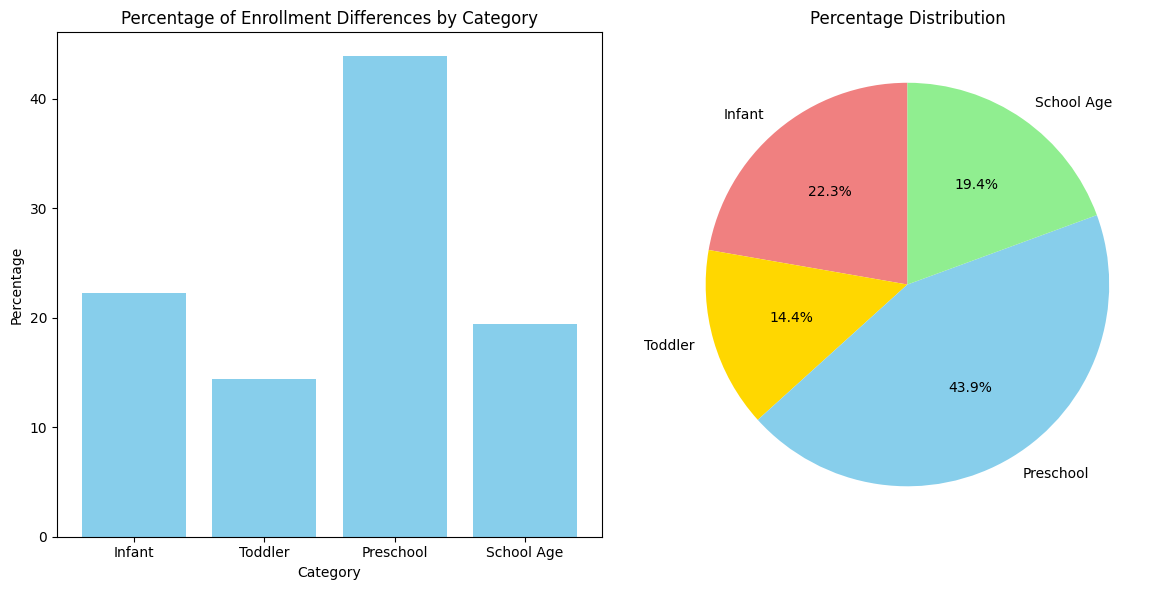

In [6]:
# More advanced number creation
# function to calculate percentages and avoid division by zero
def calculate_percentage(numerator, denominator):
    return (numerator / denominator * 100) if denominator > 0 else None

def calculate_diff(first_num, second_num):
    return (second_num - first_num)

# Count the number of "yes" answers and cal %
yes_count = (df['Any classrooms not open due to staff shortage?'] == 'Yes').sum()

ideal_enrollment_infant = column_sums.get('ideal enrollment-Infant', 0)
current_enrollment_infant = column_sums.get('current enrollment-Infant', 0)
ideal_enrollment_toddler = column_sums.get('ideal enrollment-Toddler', 0)
current_enrollment_toddler = column_sums.get('current enrollment-Toddler', 0)
ideal_enrollment_preschool = column_sums.get('ideal enrollment-Preschool', 0)
current_enrollment_preschool = column_sums.get('current enrollment-Preschool', 0)
ideal_enrollment_school_age = column_sums.get('ideal enrollment-School Age', 0)
current_enrollment_school_age = column_sums.get('current enrollment-School Age', 0)

diff_infant = calculate_diff(current_enrollment_infant, ideal_enrollment_infant)
diff_toddler = calculate_diff(current_enrollment_toddler, ideal_enrollment_toddler)
diff_preschool = calculate_diff(current_enrollment_preschool, ideal_enrollment_preschool)
diff_school_age = calculate_diff(current_enrollment_school_age, ideal_enrollment_school_age)

shortage_perc = calculate_percentage(yes_count, unique_respondents)
enrollment_perc_infant = calculate_percentage(current_enrollment_infant, ideal_enrollment_infant)
enrollment_perc_toddler = calculate_percentage(current_enrollment_toddler, ideal_enrollment_toddler)
enrollment_perc_preschool = calculate_percentage(current_enrollment_preschool,ideal_enrollment_preschool)
enrollment_perc_school_age = calculate_percentage(current_enrollment_school_age, ideal_enrollment_school_age)

print(f"For Centers:")

print(f"Total number of respondents: {unique_respondents}")
print(f"Percentage of respondents that have unopened classrooms: {shortage_perc:.2f}%")
print(f"Percentage of enrollment for infants: {enrollment_perc_infant:.2f}%")
print(f"Percentage of enrollment for toddlers: {enrollment_perc_toddler:.2f}%")
print(f"Percentage of enrollment for preschool: {enrollment_perc_preschool:.2f}%")
print(f"Percentage of enrollment for school age: {enrollment_perc_school_age:.2f}%")

data = {
    'Category': ['Infant', 'Toddler', 'Preschool', 'School Age'],
    'Difference': [diff_infant, diff_toddler, diff_preschool, diff_school_age]
}

# Create a DataFrame
Perc_of_total_df = pd.DataFrame(data)

# Calculate percentages
Perc_of_total_df['Percentage'] = Perc_of_total_df['Difference'] / Perc_of_total_df['Difference'].sum() * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar Chart
axes[0].bar(Perc_of_total_df['Category'], Perc_of_total_df['Percentage'], color='skyblue')
axes[0].set_title('Percentage of Enrollment Differences by Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Percentage')

# Pie Chart
axes[1].pie(Perc_of_total_df['Percentage'], labels=Perc_of_total_df['Category'], autopct='%1.1f%%', startangle=90,
            colors=['lightcoral', 'gold', 'skyblue', 'lightgreen'])
axes[1].set_title('Percentage Distribution')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Conclusions

From the updated analysis, we observe the following trends:

### Enrollment Gaps by Age Group
| Age Group      | Current Enrollment | Ideal Enrollment | Absolute Gap | Gap (%)   |
|----------------|--------------------|------------------|--------------|-----------|
| **Infant**     | 884                | 1,274            | 390          | 30.6%     |
| **Toddler**    | 1,216              | 1,469            | 253          | 17.2%     |
| **Preschool**  | 2,507              | 3,276            | 769          | 23.5%     |
| **School Age** | 2,107              | 2,447            | 340          | 13.9%     |


<br>
<br>

$$
\begin{aligned}
\text{Gap Percentage (Group)} = \frac{\text{Ideal Enrollment - Current Enrollment}}{\text{Ideal Enrollment}} \times 100
\end{aligned}
$$



### Analysis Highlights
- **Preschool** dominates in absolute numbers, accounting for the largest enrollment gap by raw count.  
- **Infant care** shows the highest relative gap (percentage) of unmet enrollment needs, indicating a critical shortage.  
- **Toddler** and **School Age** categories present more modest gaps, suggesting that these groups are closer to meeting ideal enrollment targets.  

These insights underscore the need for targeted interventions in Preschool and Infant care to address the larger gaps and align current enrollment with ideal targets.
